# Function

In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import random
import h5py
import glob, os, time
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import logging
from PIL import Image
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Model

In [2]:
class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            
            # orderdict to list
            weight = [lay[1] for lay in mod.state_dict().items()]
            # apply
            for i, layer in enumerate(self.frontend.state_dict().items()):
                layer[1].data[:] = weight[i].data[:]
                
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            
                
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)                

In [3]:
# model = CSRNet()
# model(torch.FloatTensor(5,3,128,128).zero_()).shape

## Dataset

### augments

In [4]:
class RandomResizedCrop:
    def __init__(self, size, scale):
        self.transform = transforms.RandomResizedCrop(size = size, scale= scale)
        
    def __call__(self, img, hot_map):
        crop_indices = self.transform.get_params(img, \
                                                 scale = self.transform.scale, \
                                                 ratio = self.transform.ratio)
        i, j, h, w = crop_indices
        return TF.resized_crop(img, i, j, h, w, self.transform.size, self.transform.interpolation),\
                TF.resized_crop(hot_map, i, j, h, w, self.transform.size, self.transform.interpolation)

class RandomRotation:
    def __init__(self, max_angle = 90):
        self.max_angle = max_angle
        
    def __call__(self, img, hot_map):
        angle = random.random() * self.max_angle
        return TF.rotate(img, angle), TF.rotate(hot_map, angle)
    
class RandomVFlip:
    def __init__(self):
        pass
    def __call__(self, img, hot_map):
        return TF.vflip(img), TF.vflip(hot_map)

class RandomHFlip:
    def __init__(self):
        pass
    def __call__(self, img, hot_map):
        return TF.hflip(img), TF.hflip(hot_map)

class FixTransforms:
    # apply the same augmentations on both input and gt
    def __init__(self, augmentations, probs):
        self.augmentations = augmentations
        self.probs = probs

    def __call__(self, img, hot_map):
        # both img, hot_map are PIL
        for i, augmentation in enumerate(self.augmentations):
            if random.random() < self.probs[i]:
                img, hot_map = augmentation(img, hot_map)
        return img, hot_map

### dataset

In [5]:
class SDD(Dataset):
    def __init__(self, size = 512):
        super(SDD, self).__init__()
        self.file_list = glob.glob('data/raw/*.h5')
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),\
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
        ])

        self.aug = FixTransforms([
            RandomHFlip(),
            RandomVFlip(),
#             RandomRotation(),
            RandomResizedCrop(size = size, scale=(0.7, 1.0)),
        ], probs = [0.5, 0.5, 1, 1])
        

    def __getitem__(self, index):
        data = h5py.File(self.file_list[index], 'r')
        xs, ys = np.asarray(data['img']), np.asarray(data['map'])
        
        xs = TF.to_pil_image(xs)
        ys = TF.to_pil_image(ys)
        
        xs, ys = self.aug(xs, ys)
        
        xs = self.transform(xs)
        ys = TF.resize(ys, [int(ys.size[1]/8), int(ys.size[0]/8)])
        ys = TF.to_tensor(ys)

        return xs, ys

    def __len__(self):
        return len(self.file_list)
    
class ValSDD(Dataset):
    def __init__(self):
        super(ValSDD, self).__init__()
        self.file_list = glob.glob('data/val/*.h5')
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),\
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
        ])

    def __getitem__(self, index):
        data = h5py.File(self.file_list[index], 'r')
        xs, ys = np.asarray(data['img']), np.asarray(data['map'])
        
        xs = TF.to_pil_image(xs)
        ys = TF.to_pil_image(ys)
        
        xs = self.transform(xs)
        ys = TF.resize(ys, [int(ys.size[1]/8), int(ys.size[0]/8)])
        ys = TF.to_tensor(ys)
        return xs, ys

    def __len__(self):
        return len(self.file_list)
    
class TestData(Dataset):
    def __init__(self):
        super(TestData, self).__init__()
        self.file_list = glob.glob('data/test/*.png')
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),\
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
        ])

    def __getitem__(self, index):
        xs = Image.open(self.file_list[index]).convert('RGB')
        xs = self.transform(xs)
        return xs

    def __len__(self):
        return len(self.file_list)

## eval func

In [6]:
def evalfunc(model, VLoader, criterion, scaling_factor):
    model.eval()
    loss, count = 0, 0
    with torch.no_grad():
        for n_count, (x, y) in enumerate(VLoader):
            output = model(x.to(device))
            loss += criterion(output, y.to(device) * scaling_factor)
            count += 1
    model.train()
    return loss/count
    

# Main

In [ ]:
n_epoch = 30
batch_size = 32
scaling_factor = 1e6


# model dir
save_dir = 'model/trial2/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# logger
logger = logging.getLogger()
hdlr = logging.FileHandler(os.path.join(save_dir, 'train.log'))
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
logger.addHandler(hdlr) 
logger.setLevel(logging.INFO)

# model
model = CSRNet().to(device)
model.train()

# dataset
d = SDD(size = 384)
DLoader = DataLoader(dataset = d, num_workers = 8, batch_size = batch_size, shuffle = True)
v = ValSDD()
VLoader = DataLoader(dataset = v, num_workers = 1, batch_size = 1, shuffle = False)

# criterion
criterion = nn.MSELoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-5)
# scheduler
scheduler = MultiStepLR(optimizer, milestones=[5,15,25], gamma=0.5)

init_epoch = 0
# init_epoch = findLastCheckpoint(save_dir=save_dir)  # load the last model in matconvnet style
# if init_epoch > 0:
#     print('resuming by loading epoch %03d' % init_epoch)
#     model.load_state_dict(\
#                 torch.load(os.path.join(save_dir, 'model_%03d.pth' % init_epoch))['stat_dict']\
#                           )
#     optimizer.load_state_dict(\
#                 torch.load(os.path.join(save_dir, 'model_%03d.pth' % init_epoch))['op_stat_dict']
#                           )

for epoch in range(init_epoch, n_epoch):
    scheduler.step(epoch)
    
    start_time = time.time()
    start_time2 = time.time()
    for n_count, (x, y) in enumerate(DLoader):
        
        optimizer.zero_grad()

        output = model(x.to(device))
        loss = criterion(output, y.to(device) * scaling_factor)
        
        loss.backward()
        optimizer.step()

        if n_count % 10 == 0: 
            if n_count % 80 == 0:
                val_loss = evalfunc(model, VLoader, criterion, scaling_factor)
                info = '%4d %4d / %4d loss = %2.4f eval_loss = %2.4f time = %2.4fsec' % \
                      (epoch+1, n_count, DLoader.__len__(), loss.item()/batch_size, \
                       val_loss, time.time()-start_time)
                logger.info(info)
                print(info)
            else:
                info = '%4d %4d / %4d loss = %2.4f time = %2.4fsec' % \
                      (epoch+1, n_count, DLoader.__len__(), loss.item()/batch_size, \
                       time.time()-start_time)
                logger.info(info)
                print(info)
                start_time = time.time()
        

    elapsed_time = time.time() - start_time
    torch.save({'stat_dict': model.state_dict(), \
                'op_stat_dict': optimizer.state_dict()
               }
               , os.path.join(save_dir, 'model_%03d.pth' % (epoch+1)))

/home/ko/test/lib/python3.5/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


   1    0 /  179 loss = 113.9058 eval_loss = 2383.6033 time = 19.8295sec
   1   10 /  179 loss = 38.5369 time = 41.2057sec
   1   20 /  179 loss = 63.5013 time = 22.6255sec
   1   30 /  179 loss = 101.5622 time = 22.0434sec
   1   40 /  179 loss = 36.5903 time = 25.6574sec
   1   50 /  179 loss = 90.5585 time = 31.3297sec
   1   60 /  179 loss = 30.6838 time = 24.9820sec
   1   70 /  179 loss = 48.5607 time = 24.8168sec
   1   80 /  179 loss = 53.0987 eval_loss = 2317.8442 time = 29.3038sec
   1   90 /  179 loss = 71.1460 time = 65.0424sec
   1  100 /  179 loss = 32.6635 time = 35.3952sec
   1  110 /  179 loss = 103.3175 time = 27.0448sec
   1  120 /  179 loss = 65.3138 time = 23.3068sec
   1  130 /  179 loss = 47.9685 time = 33.1418sec
   1  140 /  179 loss = 45.5062 time = 33.1299sec
   1  150 /  179 loss = 60.4040 time = 39.3357sec
   1  160 /  179 loss = 49.7029 eval_loss = 2323.5525 time = 43.9857sec
   1  170 /  179 loss = 51.6458 time = 78.8289sec
   2    0 /  179 loss = 42.5937

In [8]:
model = CSRNet().to(device)
model.load_state_dict(torch.load('model/trial/model_050.pth')['stat_dict'])

<All keys matched successfully>

In [9]:
dd = TestData()
DD = DataLoader(dataset = dd, num_workers = 1, batch_size = 1, shuffle = False)
model.eval()

# for n_count, (x, y) in enumerate(DD):
#     output = model(x.to(device))
#     print(output.shape, y.shape)
#     print(criterion(output, y.to(device) * 1e5).item())

for n_count, x in enumerate(DD):
    output = model(x.to(device))

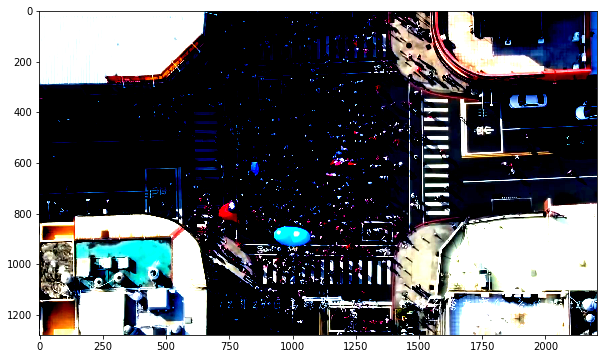

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(x[0].permute(1,2,0).cpu().detach().numpy())
plt.clim(0,1)

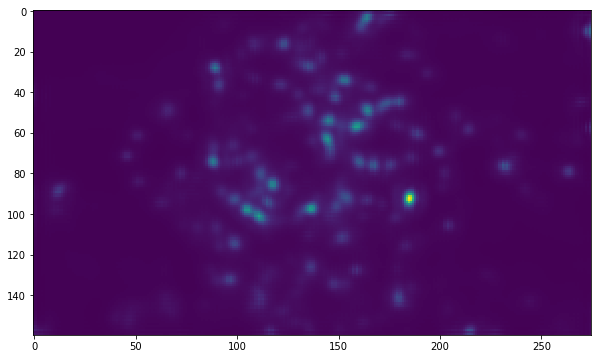

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(output[0,0].cpu().detach().numpy())
# plt.clim(0,1)


In [76]:
output[0,0].cpu().detach().numpy()

array([[0.13128184, 0.13128184, 0.13128184, ..., 0.13128184, 0.13128184,
        0.13128184],
       [0.13128184, 0.13128184, 0.13128184, ..., 0.13128184, 0.13128184,
        0.13128184],
       [0.13128184, 0.13128184, 0.13128184, ..., 0.13128184, 0.13128184,
        0.13128184],
       ...,
       [0.13128184, 0.13128184, 0.13128184, ..., 0.13128184, 0.13128184,
        0.13128184],
       [0.13128184, 0.13128184, 0.13128184, ..., 0.13128184, 0.13128184,
        0.13128184],
       [0.13128184, 0.13128184, 0.13128184, ..., 0.13128184, 0.13128184,
        0.13128184]], dtype=float32)

In [77]:
y[0,0].cpu().detach().numpy()

array([[1.3040019e-05, 1.3749501e-05, 1.4482434e-05, ..., 6.0674559e-08,
        5.2570879e-08, 4.6061267e-08],
       [1.3260634e-05, 1.3982119e-05, 1.4727452e-05, ..., 6.3794197e-08,
        5.5258891e-08, 4.8404139e-08],
       [1.3420516e-05, 1.4150699e-05, 1.4905019e-05, ..., 6.7365981e-08,
        5.8332539e-08, 5.1079883e-08],
       ...,
       [8.9929678e-08, 1.4106423e-07, 2.2221670e-07, ..., 1.9495039e-07,
        1.8455245e-07, 1.7570336e-07],
       [5.1491373e-08, 8.0769674e-08, 1.2723545e-07, ..., 1.6418859e-07,
        1.5539419e-07, 1.4791146e-07],
       [2.9819347e-08, 4.6774804e-08, 7.3683758e-08, ..., 1.4000713e-07,
        1.3248311e-07, 1.2608241e-07]], dtype=float32)

In [79]:
# torch.min(y)

In [115]:
# d = SDD()
# D = DataLoader(dataset = d, num_workers = 1, batch_size = 1, shuffle = False)
# model = CSRNet().to(device)
# print(D.__len__())
# for idx, (x,y) in enumerate(D):
#     print(x.shape, torch.max(x), x.dtype)
#     print(y.shape, torch.max(y), y.dtype)
#     print(model(x.to(device)).shape)
#     break
d = TestData()
D = DataLoader(dataset = d, num_workers = 1, batch_size = 1, shuffle = False)
model = CSRNet().to(device)
print(D.__len__())
for idx, (x) in enumerate(D):
    print(x.shape, torch.max(x), x.dtype)
#     print(y.shape, torch.max(y), y.dtype)
    print(model(x.to(device)).shape)
    break

1
torch.Size([1, 3, 1360, 1714]) tensor(2.6400) torch.float32
torch.Size([1, 1, 170, 214])


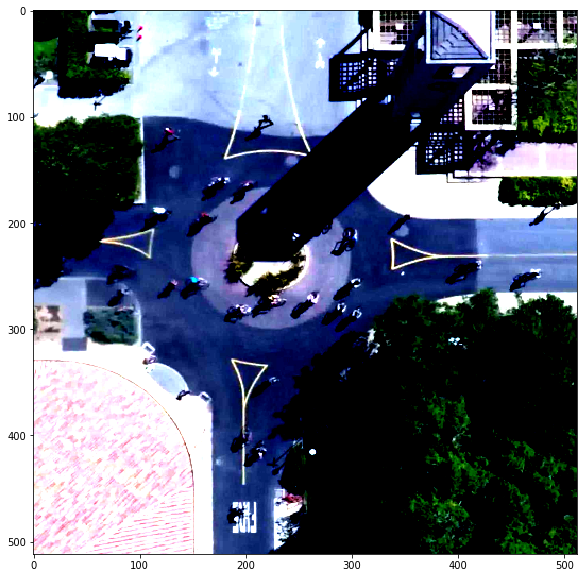

In [98]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(x[0].permute(1,2,0).numpy())
plt.clim(0,1)


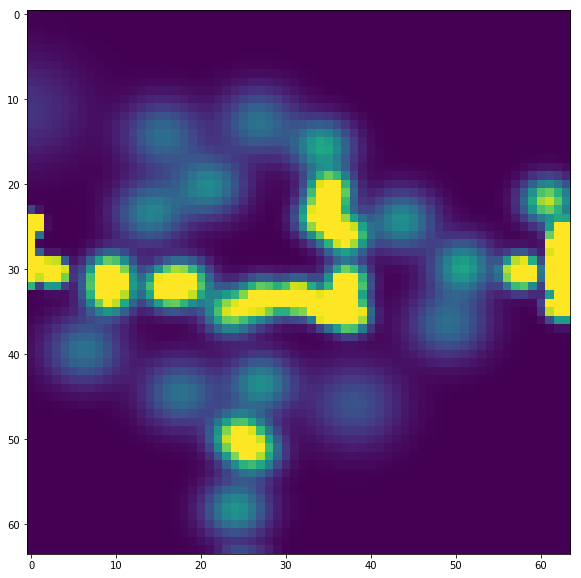

In [99]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(y[0,0,...].numpy()*10000)
plt.clim(0,1)